<h1 style="text-align: center;"><b>MOONS/MNIST classification using Logistic Regression, a fully connected neural network, and CNN</b></h1>






In [ ]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# MOONS dataset

Let's generate a dataset and take a look at it!

In [ ]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

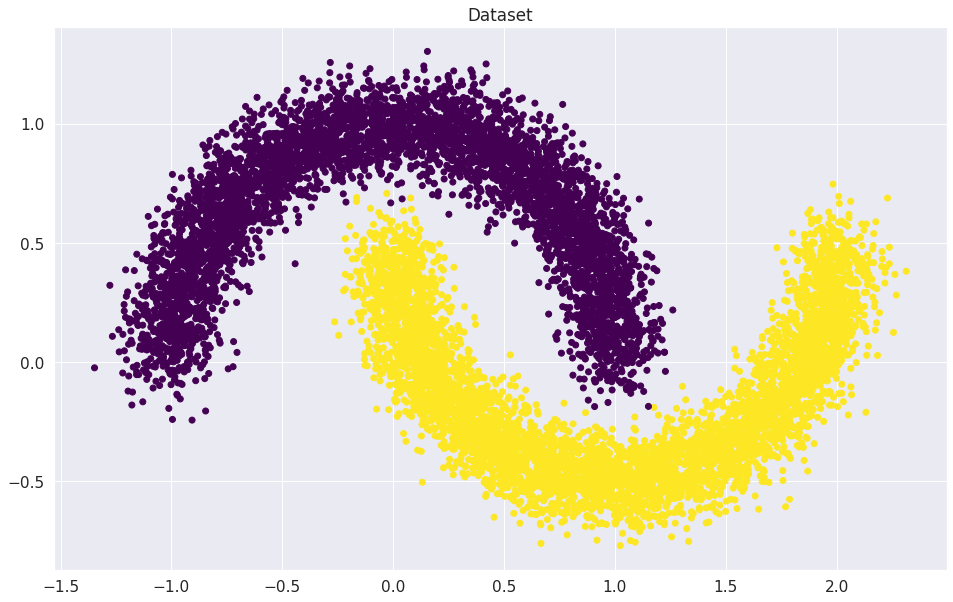

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Let's do a train/test split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Loading data
In PyTorch, data loading usually occurs on the fly (sometimes datasets do not fit into RAM). For this we will use `Dataset` and `DataLoader` are used.

1. `Dataset` loads each object individually.

2. `DataLoader` groups objects from `Dataset` into batches.

Since our dataset is quite small we will use `TensorDataset`. All we need is to convert from a numpy array to a tensor with type `torch.float32`.

### Let's create tensors with training and test data

In [ ]:
X_train_t = torch.FloatTensor(X_train)
y_train_t = torch.FloatTensor(y_train)
X_val_t = torch.FloatTensor(X_val)
y_val_t = torch.FloatTensor(y_val)

###Let's create `Dataset` and `DataLoader` with training and test data

In [ ]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression

**Let's remember what is logistic regression**
Let's take a look at what happens in logistic regression. At the input, we have an object-feature matrix X and a column-vector $y$ - labels from $\{0, 1\}$ for each object. We want to find a weight matrix $W$ and a bias $b$ (bias) such that our $XW + b$ model will somehow predict the object's class. As you can see at the output, our model can produce a number in the range from $(-\infty;\infty)$. This output is usually called "logits" (logits). We need to transfer it to the interval from $[0;1]$ in order for it to give us the probability that the object belongs to class oneю It is also better that this function be monotonic, quickly calculated, have a derivative and have $-\infty$ the value $0$, and on $+\infty$ it had the value $1$. Such a class of functions is called a sigmoid. Most often, as a sigmoid, they take
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Let's implement logistic regression

Let's write a PyTorch module that implements $logits = XW + b$, where $W$ and $b$ are parameters (`nn.Parameter`) of the model. In other words, here we implement the `nn.Linear` module from scratch. Also, we initialize the weights with a normal distribution (`torch.randn`).

In [ ]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(out_features, in_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.zeros(out_features))

    def forward(self, x):
        w = torch.transpose(self.weights, 0, 1)
        x =  x @ w
        if self.bias:
            x +=  self.bias_term
        return x

In [ ]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

Let's calculate how many trainable parameters the resulting model has?

In [ ]:
sum(p.numel() for p in linear_regression.parameters())

3

### Train loop

Here is a pseudocode to help you figure out what's going on during training

```python
for epoch in range(max_epochs): # <----------- iterate over the dataset multiple times
     for x_batch, y_batch in dataset: # <------ iterate over the dataset.
                                      # Since we use SGD and not GD, we take batches of a given size
         optimizer.zero_grad() # <------------- reset model gradients
         outp = model(x_batch) # <------------- get loggits from model
         loss = loss_func(outp, y_batch) # <--- calculate "loss" for logistic regression
         loss.backward() # <------------------- calculate gradients
         optimizer.step() # <----------------- doing a gradient descent step
         if convergence: # <------------------- in case of convergence exit the loop
             break
```

In the code below, we will add `accuracy` and `loss` logging.

###Let's implement a learning cycle

In [ ]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp =  linear_regression(X_batch)
        loss =  loss_function(outp,  y_batch.unsqueeze(1))
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = torch.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)

        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.3125
Iteration: 100
Batch accuracy: 0.859375
Iteration: 200
Batch accuracy: 0.8671875
Iteration: 300
Batch accuracy: 0.9140625
Iteration: 400
Batch accuracy: 0.890625
Iteration: 500
Batch accuracy: 0.9140625
Iteration: 600
Batch accuracy: 0.875

Iteration: 696.Convergence. Stopping iterations.


### Let's see how the loss changed by iterations

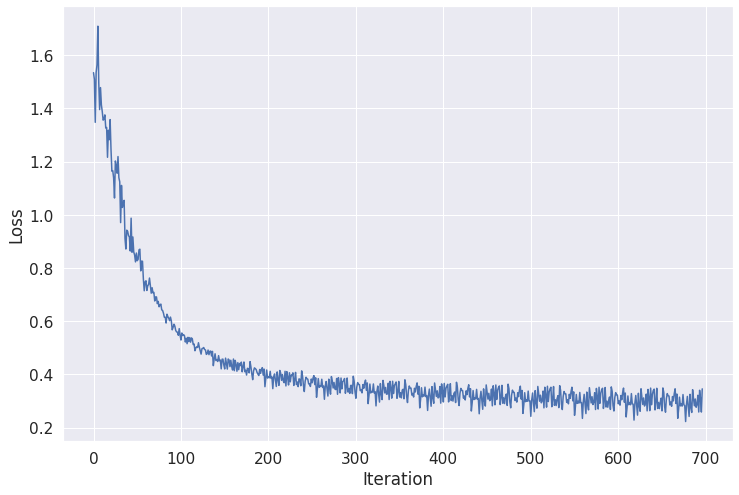

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

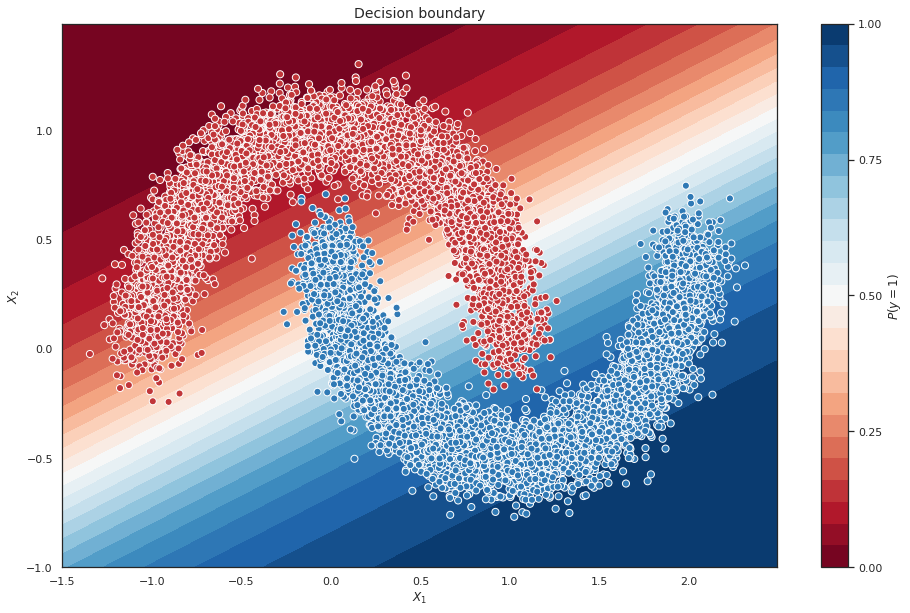

In [ ]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Let's implement predict and calculate accuracy on test.

In [ ]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        preds = model(x_batch)
        preds = (torch.sigmoid(preds) > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(y_val_t.type(torch.float32), predict(val_dataloader, linear_regression))

0.872

**After learning the accuracy is:** 0.872

# MNIST dataset
The MNIST dataset contains handwritten numbers. Let's load the dataset and create DataLoaders.

In [ ]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader =  DataLoader(train_dataset, batch_size=128)
valid_dataloader =  DataLoader(val_dataset, batch_size=128)

## Option 1: Fully Connected Neural Networks
We first solve MNIST using a fully connected neural network.

In [ ]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Simple fully connected neural network

Let's create a fully connected neural network using the Sequential class. The network consists of:
* Flattening a matrix into a vector (nn.Flatten);
* Two hidden layers of 128 neurons with nn.ELU activation function;
* Output layer with 10 neurons.

Set the learning loss (cross-entropy).

In [ ]:
activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    nn.ELU(),
    nn.Linear(128, 128),
    nn.ELU(),
    nn.Linear(128, 10)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop

Let's look at the pseudo code below, which will be suitable for solving 90% of similar tasks.


```python
for epoch in range(max_epochs): # <--------------- iterate over the dataset several times
     for k, dataloader in loaders.items(): # <----- multiple dataloaders for train/valid/test
         for x_batch, y_batch in dataloader: # <--- iterate over the dataset. Since we use SGD and not GD, we take batches of a given size
             if k == "train":
                 model.train() # <------------------ put the model into train mode
                 optimizer.zero_grad() # <--------- reset model gradients
                 outp = model(x_batch)
                 loss = criterion(outp, y_batch) # <-calculate "loss" for logistic regression
                 loss.backward() # <--------------- calculate gradients
                 optimizer.step() # <-------------- do the gradient descent step
             else: # <----------------------------- test/eval
                 model.eval() # <------------------ put the model into eval mode
                 with torch.no_grad(): # <--------- DO NOT count gradients
                     outp = model(x_batch) # <------------- get loggits from model
             count_metrics(outp, y_batch) # <-------------- count metrics
```

###Let's implement a learning cycle

In [ ]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = (abs(preds - y_batch) == 0).sum()
            all = len(y_batch)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.8813666666666666
Loader: valid. Accuracy: 0.9294
Epoch: 2
Loader: train. Accuracy: 0.9435833333333333
Loader: valid. Accuracy: 0.9474
Epoch: 3
Loader: train. Accuracy: 0.9607833333333333
Loader: valid. Accuracy: 0.9535
Epoch: 4
Loader: train. Accuracy: 0.96905
Loader: valid. Accuracy: 0.9634
Epoch: 5
Loader: train. Accuracy: 0.9747666666666667
Loader: valid. Accuracy: 0.9689
Epoch: 6
Loader: train. Accuracy: 0.9789833333333333
Loader: valid. Accuracy: 0.9699
Epoch: 7
Loader: train. Accuracy: 0.98235
Loader: valid. Accuracy: 0.9707
Epoch: 8
Loader: train. Accuracy: 0.98445
Loader: valid. Accuracy: 0.9701
Epoch: 9
Loader: train. Accuracy: 0.9862333333333333
Loader: valid. Accuracy: 0.9678
Epoch: 10
Loader: train. Accuracy: 0.9866166666666667
Loader: valid. Accuracy: 0.9716


### Let's test different activation functions.
For each activation function, let's calculate the validation accuracy array. It is best to implement this as a function that takes an activation as input and receives an array of accuracies.

In [ ]:
def create_model(activation):
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, 128),
        activation(),
        nn.Linear(128, 128),
        activation(),
        nn.Linear(128, 10)
    )
    return model

def train_model(model):
    loaders = {"train": train_dataloader, "valid": valid_dataloader}
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)
                preds = outp.argmax(-1)
                correct = (abs(preds - y_batch) == 0).sum()
                all = len(y_batch)
                epoch_correct += correct.item()
                epoch_all += all
                if k == "train":
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)
    return accuracy["valid"]

def test_activation_function(activation):
    model = create_model(activation)
    return train_model(model)

In [ ]:
plain_accuracy = test_activation_function(Identical)
relu_accuracy = test_activation_function(nn.ReLU)
elu_accuracy = test_activation_function(nn.ELU)
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)

Epoch: 1
Loader: train. Accuracy: 0.8630166666666667
Loader: valid. Accuracy: 0.8883
Epoch: 2
Loader: train. Accuracy: 0.8955833333333333
Loader: valid. Accuracy: 0.8991
Epoch: 3
Loader: train. Accuracy: 0.9000166666666667
Loader: valid. Accuracy: 0.8987
Epoch: 4
Loader: train. Accuracy: 0.9020833333333333
Loader: valid. Accuracy: 0.8987
Epoch: 5
Loader: train. Accuracy: 0.9046166666666666
Loader: valid. Accuracy: 0.8983
Epoch: 6
Loader: train. Accuracy: 0.9059
Loader: valid. Accuracy: 0.8992
Epoch: 7
Loader: train. Accuracy: 0.9067333333333333
Loader: valid. Accuracy: 0.8996
Epoch: 8
Loader: train. Accuracy: 0.90825
Loader: valid. Accuracy: 0.9005
Epoch: 9
Loader: train. Accuracy: 0.90945
Loader: valid. Accuracy: 0.9018
Epoch: 10
Loader: train. Accuracy: 0.9104166666666667
Loader: valid. Accuracy: 0.9036
Epoch: 1
Loader: train. Accuracy: 0.86545
Loader: valid. Accuracy: 0.9231
Epoch: 2
Loader: train. Accuracy: 0.9311333333333334
Loader: valid. Accuracy: 0.9487
Epoch: 3
Loader: train. 

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

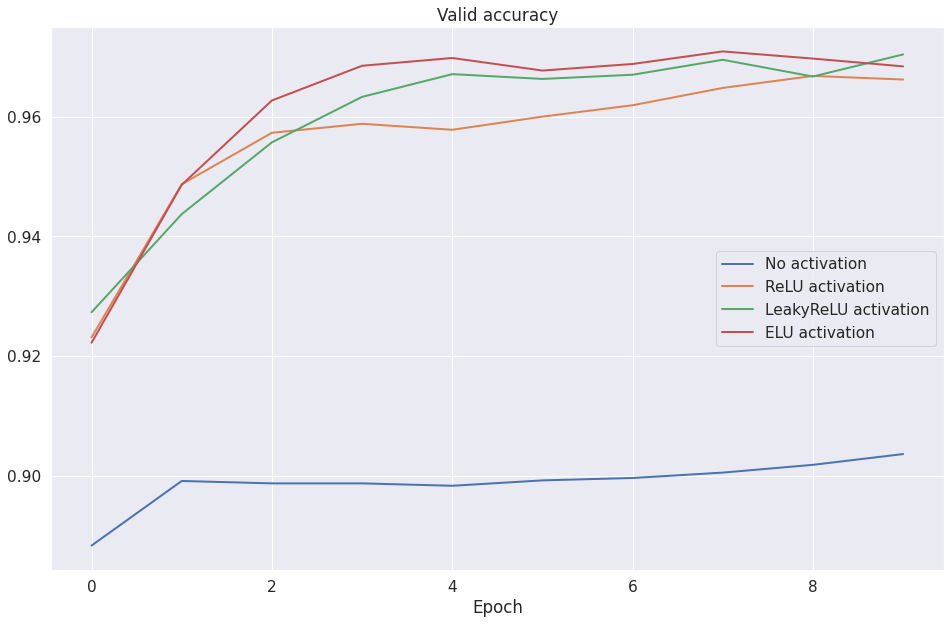

In [ ]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

## Option 2. Convolutional Neural Networks

### Let's implement LeNet

If we make convolution parameters trainable, we can achieve good results for computer vision problems. Let's try to implement the LeNet architecture proposed back in 1998!
This time we use a modular structure, without the help of the Sequential class.

Our neural network will consist of
* 3x3 convolutions (1 map in, 6 out) with ReLU activation;
* MaxPooling 2x2;
* 3x3 convolutions (6 maps in, 16 maps out) with ReLU activation;
* MaxPooling 2x2;
* Flattening (nn.Flatten);
* Fully connected layer with 120 neurons and ReLU activation;
* Fully connected layer with 84 neurons and ReLU activation;
* Output layer of 10 neurons.

In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)


    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1, -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Let's train CNN
We use the training code that we wrote for a fully connected neural network.

In [ ]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = (abs(preds - y_batch) == 0).sum()
            all = len(y_batch)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.8705666666666667
Loader: valid. Accuracy: 0.9615
Epoch: 2
Loader: train. Accuracy: 0.9647
Loader: valid. Accuracy: 0.967
Epoch: 3
Loader: train. Accuracy: 0.9759833333333333
Loader: valid. Accuracy: 0.9777
Epoch: 4
Loader: train. Accuracy: 0.9813666666666667
Loader: valid. Accuracy: 0.9834
Epoch: 5
Loader: train. Accuracy: 0.9852333333333333
Loader: valid. Accuracy: 0.9869
Epoch: 6
Loader: train. Accuracy: 0.98785
Loader: valid. Accuracy: 0.9882
Epoch: 7
Loader: train. Accuracy: 0.9893166666666666
Loader: valid. Accuracy: 0.9892
Epoch: 8
Loader: train. Accuracy: 0.9909666666666667
Loader: valid. Accuracy: 0.9898
Epoch: 9
Loader: train. Accuracy: 0.9926666666666667
Loader: valid. Accuracy: 0.9892
Epoch: 10
Loader: train. Accuracy: 0.9934
Loader: valid. Accuracy: 0.9889


In [ ]:
lenet_accuracy = accuracy["valid"]

Compare with previous results, where they were trained using a fully connected neural network.

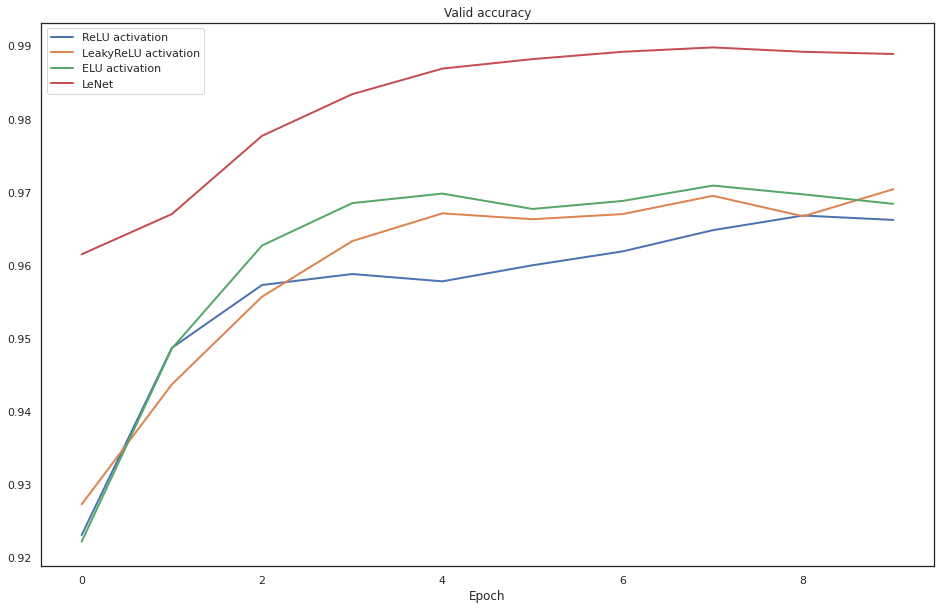

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()